# Commits Analysis

This notebook presents the following information, for all dataset splits - Notebooks datasets for both Software Enginnering purposes (Notebooks SE) and educational purposes (Notebooks Edu.), and Python datasets for Software Enginnering purposes (Python SE) and educational  purposes (Python Edu.), and for the Kaggle dataset:

- Number of total commits of a given repository
- Commit frequency of a given repository: number of days elapsed between 2 consecutives commits
- Number of unique authors that have contributed to a given repository 
- Commit message length
- Statiscal analysis for the previous items (mean, median, standard deviation, Mann-Whitney test and Cohen D effect size)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import math
from collections import Counter
import pingouin as pg
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Auxiliar Functions

In [2]:
def get_commit_diff_time_per_repo(df, split):
    """ Gets the difference, in days, between each commit pushed
        to a given repository. Repositories
        are treated separately.
    """
    # copying the dataframe to prevent modification of the original one:
    df = df.copy()
    df = df.dropna(subset=['commit_date'])
    # converting commit dates to datetime objects:
    df['commit_date'] = pd.to_datetime(df['commit_date'], errors='coerce')
    # getting the difference, in days, between successive commits:
    df['days_diff'] = df.groupby('repo_url')['commit_date'].diff().apply(lambda x: abs(x.days) if pd.notnull(x) else 0)
    
    print(df['days_diff'].describe())
    df['split'] = split

    return df

def get_commit_avg_diff_time_per_repo(df, split):
    """ Gets the average difference, in days, between each commit pushed
        to a given repository. Repositories
        are treated separately. The average of commit frequency is computed
        per each repository url."""

    # copying the dataframe to prevent modification of the original one:
    df = df.copy()
    df = df.dropna(subset=['commit_date'])
    df['commit_date'] = pd.to_datetime(df['commit_date'], errors='coerce')
    # getting the difference, in days, between successive commits:
    df['days_diff'] = df.groupby('repo_url')['commit_date'].diff().apply(lambda x: abs(x.days) if pd.notnull(x) else 0)
    # getting the mean of days elapsed between successive commits, per repository:
    avg_days_diff = df.groupby('repo_url')['days_diff'].mean().reset_index()

    df_merged = pd.merge(df, avg_days_diff, on='repo_url', suffixes=('', '_avg'))

    # eliminating repeated repo urls, since we only want
    # the average per repository
    # and keeping only one occurrence of each repo_url
    df_merged = df_merged.drop_duplicates(subset=['repo_url'], keep='first')
    df_merged['split'] = split
    df_merged = df_merged[['repo_url', 'days_diff_avg', 'split']]

    return df_merged

def get_commit_msg_length(df, split: str):
    """ Gets the number of chars of each commit message"""
    # copying the dataframe to prevent modification of the original one:
    df = df.copy()
    df['commit_msg'] = df['commit_msg'].fillna('').astype(str)
    df['commit_length'] = df['commit_msg'].apply(preprocess_commit)
    print(df['commit_length'].describe())
    df['split'] = split

    return df

def preprocess_commit(commit_message):
    # cleaning commit messages:
    cleaned_string = commit_message.replace(' ', '').replace('\n', '')
    return len(cleaned_string)

def shannon_entropy(commit_message):
    """calculate the Shannon entropy of a commit message"""
    
    # counting the frequency of each character 
    data_length = len(commit_message)
    char_frequencies = Counter(commit_message)
    
    # shannon entropy: measure of the amount of uncertainty or randomness in a 
    # set of symbols and
    # calculates the probability of each character appearing in the text
    entropy = -sum((count / data_length) * math.log2(count / data_length) for 
                   count in char_frequencies.values())
    
    return entropy

def entropy_all_commits(df, split: str):
    """Applying the entropy function in commit messages of all
    commits of a given split"""

    # copying the dataframe to prevent modification of the original one:
    df = df.copy()
    df['commit_msg'] = df['commit_msg'].fillna('').astype(str)
    df['commit_length'] = df['commit_msg'].apply(preprocess_commit)
    # computing entropy for commit messages:
    df['commit_msg_entropy'] = df['commit_msg'].apply(shannon_entropy)
    df['split'] = split

    print(df['commit_msg_entropy'].describe())

    return df

def get_number_commits_per_repo(df, split: str):
    """Get commits count per repository"""
    # preventing changing the dataframe passed as parameter:
    df = df.copy()
    df['commit_count'] = df.groupby('repo_url')['commit_sha'].transform('count')
    # keeping only one occurrence of each repo_url
    df = df.drop_duplicates(subset=['repo_url'], keep='first')
    df = df[['repo_url', 'commit_count']]
    df['split'] = split
    print(df['commit_count'].describe())
    
    return df


def get_unique_authors_count(df, split: str):
    """Get unique authors for each repository separately. It is important
    to use the user_id queried from GitHub API instead of user 'name' or 'email',
    to prevent inconsistencies  (e.g: if a user changes its email account,
    a user may be counted incorrectly twice)"""

    # copying the dataframe to prevent modification of the original one:
    df = df.copy()
    df['unique_authors'] = df.groupby('repo_url')['user_id'].transform('nunique')
    # gettign the name of the authors, for debugging purposes:
    df_grouped = df.groupby('repo_url')['name'].apply(list).reset_index()
    # merging the grouped data back into the original dataframe
    df_merged = pd.merge(df, df_grouped, on='repo_url', suffixes=('', '_authors'))

    # renaming the column to 'authors', mapping the unique authors per each
    # repo url:
    df_merged = df_merged.rename(columns={'name_authors': 'authors'})

    # eliminaitng duplicated rows:
    df_merged = df_merged.drop_duplicates(subset=['repo_url'], keep='first')
    df_merged = df_merged[['repo_url','unique_authors', 'authors']]

    df_merged['split'] = split

    return df_merged

def get_mann_test_and_cohen_d(df_column1, df_column2):
    """Applies Mann-Whitney hypothesis testing to 2 group sets
    passed as input (2 dataframe columns passed as parameter).
    Also gets Cohen D coefficient between these 2 groups,
    that is an effect size measure if two groups have similar 
    standard deviations and are of the same size 
    """

    statistic, p_value = mannwhitneyu(df_column1, df_column2)
    print(f"Mann-Whitney U statistic: {statistic}")
    # printing more decimals:
    formatted_p_value = "{:.10f}".format(p_value)
    print(f"P-value: {formatted_p_value}")
    
    # returning the absolute value of cohen d:
    cohen_d = pg.compute_effsize(df_column1, df_column2, eftype='cohen')
    cohen_d = np.abs(cohen_d)
    print(f"Absolute value of cohen d: {cohen_d}")
    if cohen_d <= 0.2:
        print(f"Very small difference between Notebooks vs Python (cohen D <= 0.2)")
    if cohen_d > 0.2 and cohen_d <= 0.5:
        print(f"Small difference between Notebooks vs Python ( 0.2 > cohen D <= 0.5)")
    if cohen_d > 0.5 and cohen_d <= 0.8:
        print(f"Medium difference between Notebooks vs Python ( 0.5 > cohen D <= 0.8)")
    if cohen_d > 0.8:
        print(f"Big difference between Notebooks vs Python (cohen D > 0.8)")


### Getting the unique authors for each split:

Number of unique authors for the Notebook data split for Software Engineer purposes: 

In [3]:
csv_SE_path = Path(Path.cwd().parent,'contributors_RQ3_RQ4_RQ5',"contributors_data_SE.csv")
authors_SE = pd.read_csv(csv_SE_path)
len(authors_SE)


10914

Number of unique authors for the Notebook data split for Educational purposes: 

In [4]:
csv_non_SE_path = Path(Path.cwd().parent,'contributors_RQ3_RQ4_RQ5',"contributors_data_non_SE.csv")
authors_non_SE = pd.read_csv(csv_non_SE_path)
len(authors_non_SE)


11412

Number of unique authors for the Python data split for Software Engineer purposes: 

In [5]:
csv_SE_py_path = Path(Path.cwd().parent,'contributors_RQ3_RQ4_RQ5',"contributors_data_SE_py.csv")
authors_SE_py = pd.read_csv(csv_SE_py_path)
len(authors_SE_py)


21195

Number of unique authors for the Python data split for educational purposes: 

In [6]:
csv_non_SE_py_path = Path(Path.cwd().parent,'contributors_RQ3_RQ4_RQ5',"contributors_data_non_SE_py.csv")
authors_non_SE_py = pd.read_csv(csv_non_SE_py_path)
len(authors_non_SE_py)


2034

In [7]:
authors_SE = get_unique_authors_count(authors_SE,'Notebook (SE)')
authors_non_SE = get_unique_authors_count(authors_non_SE, 'Notebook (Edu)')
authors_SE_py = get_unique_authors_count(authors_SE_py, 'Python (SE)')
authors_non_SE_py = get_unique_authors_count(authors_non_SE_py, 'Python (Edu)')

### Analysis of Unique authors for the Notebooks (SE) split:

The following cells present metrics (mean, standard deviation, quartiles, minimum and maximum values) for the number of unique contributing authors per repository 

'Count' is the number of repositories urls in the given split. Metrics for the unique authors per repository for the Notebooks data split for Software Engineer purposes:

In [8]:
authors_SE['unique_authors'].describe()

count    375.00000
mean      29.10400
std       64.88379
min        1.00000
25%        3.00000
50%        8.00000
75%       25.50000
max      406.00000
Name: unique_authors, dtype: float64

### Analysis of Unique authors for the Notebooks (Edu) split:

'Count' is the number of repositories urls in the given split. Metrics for the unique authors per repository for the Notebooks data split for educational purposes:

In [9]:
authors_non_SE['unique_authors'].describe()

count    517.000000
mean      22.073501
std       55.112345
min        1.000000
25%        2.000000
50%        5.000000
75%       14.000000
max      477.000000
Name: unique_authors, dtype: float64

### Analysis of Unique authors for the Python (SE) split:

'Count' is the number of repositories urls in the given split. Metrics for the unique authors per repository for the Python data split for Software Engineer purposes:

In [10]:
authors_SE_py['unique_authors'].describe()

count    606.000000
mean      34.975248
std       58.459093
min        1.000000
25%        4.250000
50%       13.000000
75%       38.000000
max      426.000000
Name: unique_authors, dtype: float64

### Analysis of Unique authors for the Python (Edu) split:

'Count' is the number of repositories urls in the given split. Metrics for the unique authors per repository for the Python data split for educational purposes:

In [11]:
authors_non_SE_py['unique_authors'].describe()

count    109.000000
mean      18.660550
std       48.568055
min        1.000000
25%        1.000000
50%        4.000000
75%       11.000000
max      318.000000
Name: unique_authors, dtype: float64

Concatenating all dataframes related to authors in a single dataframe, to facilitate plotting:

In [12]:
authors_all_splits = pd.concat([authors_SE,
                                authors_non_SE,
                                authors_SE_py,
                                authors_non_SE_py
                                ])

In [13]:
authors_all_splits.head(5)

,repo_url,unique_authors,authors,split
0,https://github.com/DeepVoltaire/AutoAugment,2,"[Philip Popien, Ali Hassani]",Notebook (SE)
2,https://github.com/JoePenna/Dreambooth-Stable-...,18,"[David B., Joe Penna, Xavier, nan, nan, Peter ...",Notebook (SE)
20,https://github.com/microsoft/FLAML,80,"[Chi Wang, Shaokun Zhang, Susan Xueqing Liu, Q...",Notebook (SE)
100,https://github.com/marceloprates/prettymaps,13,"[Marcelo de Oliveira Rosa Prates, Christoph Ri...",Notebook (SE)
113,https://github.com/megvii-research/CoNR,7,"[Ailin Huang, hzwer, Transp. Chan, Ryan, Shuch...",Notebook (SE)


### Getting the number of commits for each split:

Number of commits for the Notebook data split for Software Engineer purposes: 

In [14]:
csv_SE_path = Path(Path.cwd(),"commits_info_active_SE_repos.csv")
commits_df_SE = pd.read_csv(csv_SE_path)
len(commits_df_SE)

334269

Number of commits for the Notebook data split for educational purposes: 

In [15]:
csv_non_SE_path = Path(Path.cwd(),"commits_info_active_non_SE_repos.csv")
commits_df_non_SE = pd.read_csv(csv_non_SE_path)
len(commits_df_non_SE)

253112

Number of commits for the Python data split for Software Engineer purposes: 

In [16]:
csv_SE_py_path = Path(Path.cwd(),"commits_info_active_SE_py_repos.csv")
commits_df_SE_py = pd.read_csv(csv_SE_py_path)
len(commits_df_SE_py)

844771

Number of commits for the Python data split for educational purposes: 

In [17]:
csv_non_SE_py_path = Path(Path.cwd(),"commits_info_active_non_SE_py_repos.csv")
commits_df_non_SE_py = pd.read_csv(csv_non_SE_py_path)
len(commits_df_non_SE_py)

39879

### Analysis of commit count the Notebooks (SE) split:

The following cells present metrics (mean, standard deviation, quartiles, minimum and maximum values) for the number of commits per repository 

'Count' is the number of repositories urls in the given split. Metrics for the number of commits per repository for the Notebook data split for Software Engineer purposes:

In [18]:
num_commits_df_SE = get_number_commits_per_repo(commits_df_SE, "Notebook (SE)")


count      376.000000
mean       889.013298
std       3001.554977
min          2.000000
25%         53.750000
50%        154.500000
75%        643.750000
max      39088.000000
Name: commit_count, dtype: float64


### Analysis of commit count for the Notebooks (Edu) split:

'Count' is the number of repositories urls in the given split. Metrics for the number of commits per repository for the Notebook data split for educational purposes:

In [19]:
num_commits_df_non_SE = get_number_commits_per_repo(commits_df_non_SE, "Notebook (Edu)")

count      523.000000
mean       483.961759
std       1222.084154
min          1.000000
25%         57.500000
50%        138.000000
75%        401.500000
max      15060.000000
Name: commit_count, dtype: float64


### Analysis of commit count for the Python (SE) split:

'Count' is the number of repositories urls in the given split. Metrics for the number of commits per repository for the Python data split for Software Engineer purposes:

In [20]:
num_commits_df_SE_py = get_number_commits_per_repo(commits_df_SE_py, "Python (SE)")


count       607.000000
mean       1391.714992
std        5983.253415
min           2.000000
25%          78.000000
50%         289.000000
75%         936.000000
max      114409.000000
Name: commit_count, dtype: float64


### Analysis of commit count for the Python (Edu) split:

'Count' is the number of repositories urls in the given split. Metrics for the number of commits per repository for the Python data split for educational purposes:

In [21]:
num_commits_df_non_SE_py = get_number_commits_per_repo(commits_df_non_SE_py, "Python (Edu)")


count     110.000000
mean      362.536364
std       746.019144
min         1.000000
25%        39.000000
50%       117.000000
75%       335.250000
max      5402.000000
Name: commit_count, dtype: float64


Concatenating all dataframes split into a single dataframe, for plotting purposes:

In [22]:
all_commits_df = pd.concat([num_commits_df_SE,
                            num_commits_df_non_SE,
                            num_commits_df_SE_py,
                            num_commits_df_non_SE_py]
                            )

### Getting the average difference, in days, between commits:

The following cells present metrics (mean, standard deviation, quartiles, minimum and maximum values) for the time between 2 successive commits in each repository

#### Analysis of elapsed average time between 2 successive commits, in days, for the Notebooks (SE) split


In [23]:
time_avg_diff_SE = get_commit_avg_diff_time_per_repo(commits_df_SE, "Notebook (SE)")

In [24]:
time_avg_diff_non_SE = get_commit_avg_diff_time_per_repo(commits_df_non_SE, "Notebook (Edu)")

In [25]:
time_avg_diff_SE_py = get_commit_avg_diff_time_per_repo(commits_df_SE_py, "Python (SE)")

In [26]:
time_avg_diff_non_SE_py = get_commit_avg_diff_time_per_repo(commits_df_non_SE_py, "Python (Edu)")

Concatenating all dataframe sinto a single one, to facilitate plotting:

In [27]:
all_time_avg_diff = pd.concat([time_avg_diff_SE,
                           time_avg_diff_non_SE,
                           time_avg_diff_SE_py,
                           time_avg_diff_non_SE_py])

## Details of the Commit Frequency for Python and Noteboooks SE/Educational

'Count' is the number of repositories urls in the given split. Metrics for the average days elapsed between 2 successive commits per repository for the Notebook data split for Software Engineer purposes:

In [28]:
time_avg_diff_SE['days_diff_avg'].describe()

count    376.000000
mean      14.092960
std       23.664551
min        0.500000
25%        2.987984
50%        6.602177
75%       15.080159
max      220.000000
Name: days_diff_avg, dtype: float64

'Count' is the number of repositories urls in the given split. Metrics for the average days elapsed between 2 successive commits per repository for the Notebook data split for educational purposes:

In [29]:
time_avg_diff_non_SE['days_diff_avg'].describe()

count    523.000000
mean      14.538514
std       25.459897
min        0.000000
25%        3.375898
50%        6.838583
75%       15.367647
max      291.250000
Name: days_diff_avg, dtype: float64

'Count' is the number of repositories urls in the given split. Metrics for the average days elapsed between 2 successive commits per repository for the Python data split for Software Engineer purposes:

In [30]:
time_avg_diff_SE_py['days_diff_avg'].describe()

count    607.000000
mean      13.672955
std       25.790709
min        0.750000
25%        3.218125
50%        7.250000
75%       13.802982
max      422.714286
Name: days_diff_avg, dtype: float64

'Count' is the number of repositories urls in the given split. Metrics for the average days elapsed between 2 successive commits per repository for the Notebook data split for educational purposes:

In [31]:
time_avg_diff_non_SE_py['days_diff_avg'].describe()

count    110.000000
mean      16.677136
std       46.035840
min        0.000000
25%        4.185322
50%        7.417733
75%       14.731219
max      472.000000
Name: days_diff_avg, dtype: float64

#### Analysis of commit length for the Notebook (SE) split:

'Count' is the number of repositories urls in the given split. Metrics for the commit message length per repository for the Notebook data split for Software Engineer purposes:

In [32]:
commit_length_SE = get_commit_msg_length(commits_df_SE, "Notebook (SE)")

count    334269.000000
mean         90.256309
std        1597.622133
min           0.000000
25%          21.000000
50%          39.000000
75%          74.000000
max      557315.000000
Name: commit_length, dtype: float64


#### Analysis of commit length for the Notebook (Edu) split:

'Count' is the number of repositories urls in the given split. Metrics for the commit message length per repository for the Notebook data split for educational purposes:

In [33]:
commit_length_non_SE = get_commit_msg_length(commits_df_non_SE, "Notebook (Edu)")

count    253112.000000
mean         48.529821
std         362.668908
min           0.000000
25%          15.000000
50%          23.000000
75%          54.000000
max      142013.000000
Name: commit_length, dtype: float64


#### Analysis of commit length for the Python (SE) split:

'Count' is the number of repositories urls in the given split. Metrics for the commit message length per repository for the Python data split for Software Engineer purposes:

In [34]:
commit_length_SE_py = get_commit_msg_length(commits_df_SE_py, "Python (SE)")

count    844771.000000
mean         97.321421
std         579.917800
min           0.000000
25%          27.000000
50%          50.000000
75%         102.000000
max      275374.000000
Name: commit_length, dtype: float64


#### Analysis of commit length for the Python (Edu) split:

'Count' is the number of repositories urls in the given split. Metrics for the commit message length per repository for the Python data split for educational purposes:

In [35]:
commit_length_non_SE_py = get_commit_msg_length(commits_df_non_SE_py, "Python (Edu)")

count    39879.000000
mean        64.414905
std        242.526870
min          0.000000
25%         18.000000
50%         37.000000
75%         57.000000
max      15237.000000
Name: commit_length, dtype: float64


Concatenating the dataframes into a single one, for plotting purposes:

In [36]:
all_commit_length = pd.concat([commit_length_SE,
                               commit_length_non_SE,
                               commit_length_SE_py,
                               commit_length_non_SE_py])

### Getting the entropy of commit messages:

'Count' is the number of repositories urls in the given split. Metrics for the commit message entropy per repository for the Notebook data split for Software Engineer purposes:

In [37]:
entropy_SE = entropy_all_commits(commits_df_SE, 'Notebook (SE)')

count    334269.000000
mean          4.095676
std           0.554617
min           0.000000
25%           3.750000
50%           4.115181
75%           4.506336
max           6.640818
Name: commit_msg_entropy, dtype: float64


'Count' is the number of repositories urls in the given split. Metrics for the commit message entropy per repository for the Notebook data split for educational purposes:

In [38]:
entropy_non_SE = entropy_all_commits(commits_df_non_SE, 'Notebook (Edu)')

count    253112.000000
mean          3.899230
std           0.577750
min          -0.000000
25%           3.572469
50%           3.845351
75%           4.329486
max           6.424693
Name: commit_msg_entropy, dtype: float64


'Count' is the number of repositories urls in the given split. Metrics for the commit message entropy per repository for the Python data split for Software Engineer purposes:

In [39]:
entropy_SE_py = entropy_all_commits(commits_df_SE_py, 'Python (SE)')

count    844771.000000
mean          4.226871
std           0.519938
min          -0.000000
25%           3.919563
50%           4.248060
75%           4.600101
max           7.005957
Name: commit_msg_entropy, dtype: float64


'Count' is the number of repositories urls in the given split. Metrics for the commit message entropy per repository for the Python data split for educational purposes:

In [40]:
entropy_non_SE_py = entropy_all_commits(commits_df_non_SE_py, 'Python (Edu)')

count    39879.000000
mean         4.101636
std          0.606329
min         -0.000000
25%          3.750000
50%          4.118580
75%          4.545455
max          5.898225
Name: commit_msg_entropy, dtype: float64


Concatenating all dataframes into a single one, for plotting purposes:

In [41]:
all_entropy_msgs = pd.concat([entropy_SE,
                              entropy_non_SE,
                              entropy_SE_py,
                              entropy_non_SE_py])

Plotting the commists and authors data, for all splits:

/tmp/ipykernel_19242/3754073330.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_commits_df, x="commit_count", y="split",
/tmp/ipykernel_19242/3754073330.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_time_avg_diff, x="days_diff_avg", y="split",
/tmp/ipykernel_19242/3754073330.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=authors_all_splits, x="unique_authors", y="split",
/tmp/ipykernel_19242/3754073330.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed 

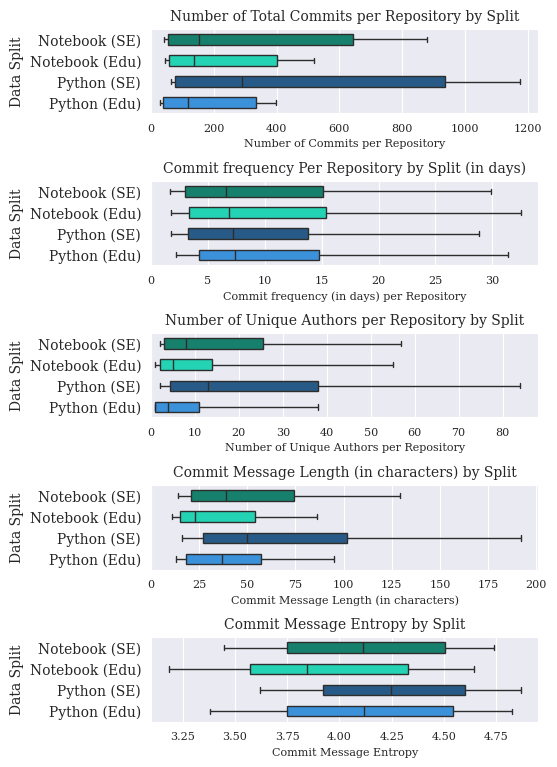

In [50]:
custom_palette = {
    'Python (SE)': '#175b96',  
    'Python (Edu)': '#2293f5',  
    'Notebook (SE)': '#069178',  
    'Notebook (Edu)': '#07f0c5',  
}
plt.rcParams['font.family'] = 'serif'

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(5, 9))

# plot number of Commits
sns.set_style("darkgrid")
sns.boxplot(data=all_commits_df, x="commit_count", y="split", 
            palette=custom_palette,whis=(20,80), showfliers = False, width=0.5,
            ax=axs[0])

axs[0].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
axs[0].set_xlim(left=0)
axs[0].set_title('Number of Total Commits per Repository by Split', fontsize=10)
axs[0].set_xlabel('Number of Commits per Repository', fontsize = 8)
axs[0].set_ylabel('Data Split', fontsize=10)
axs[0].tick_params(axis='x', labelsize=8)

# plot average commit frequency (in days)
sns.set_style("darkgrid")
sns.boxplot(data=all_time_avg_diff, x="days_diff_avg", y="split", 
            palette=custom_palette, whis=(10,90), showfliers = False, width=0.5,
            ax=axs[1])

axs[1].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
axs[1].set_xlim(left=0)
axs[1].set_title('Commit frequency Per Repository by Split (in days)', fontsize=10)
axs[1].set_xlabel('Commit frequency (in days) per Repository',fontsize = 8)
axs[1].set_ylabel('Data Split', fontsize = 10)
axs[1].tick_params(axis='x', labelsize=8)

# plot number of Unique Authors:
sns.set_style("darkgrid")
sns.boxplot(data=authors_all_splits, x="unique_authors", y="split", 
            palette=custom_palette, whis=(10,90), showfliers = False, width=0.5,
            ax=axs[2])

axs[2].xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
axs[2].set_xlim(left=0)
axs[2].set_xlabel('Number of Unique Authors per Repository',fontsize = 8)
axs[2].set_ylabel('Data Split', fontsize = 10)
axs[2].set_title('Number of Unique Authors per Repository by Split', fontsize = 10)
axs[2].tick_params(axis='x', labelsize=8)

# plot commit Length
sns.set_style("darkgrid")
sns.boxplot(data=all_commit_length, x="commit_length", y="split", 
            palette=custom_palette, whis=(10,90), showfliers = False, width=0.5,
            ax=axs[3])
axs[3].set_title('Commit Message Length (in characters) by Split', fontsize=10)
axs[3].set_xlim(left=0)
axs[3].set_xlabel('Commit Message Length (in characters)', fontsize = 8)
axs[3].set_ylabel('Data Split',fontsize = 10)
axs[3].tick_params(axis='x', labelsize=8)

# plot entropy
sns.set_style("darkgrid")
sns.boxplot(data=all_entropy_msgs, x="commit_msg_entropy", y="split", 
            palette=custom_palette, whis=(10,90), showfliers = False, width=0.5,
            ax=axs[4])
axs[4].set_title('Commit Message Entropy by Split', fontsize=10)
axs[4].set_xlabel('Commit Message Entropy', fontsize = 8)
axs[4].set_ylabel('Data Split',fontsize = 10)
axs[4].tick_params(axis='x', labelsize=8)

plt.subplots_adjust(hspace=0.8)
plt.savefig("commits_analyis.pdf", format='pdf',bbox_inches='tight')
plt.show()


## Statistical Tests (between Notebooks and Python)

In [43]:
all_commits_notebooks = pd.concat([num_commits_df_SE,
                            num_commits_df_non_SE
                            ])

all_commits_python = pd.concat([num_commits_df_SE_py,
                                num_commits_df_non_SE_py])

all_time_avg_diff_notebooks = pd.concat([time_avg_diff_SE,
                           time_avg_diff_non_SE
                           ])

all_time_avg_diff_python = pd.concat([time_avg_diff_SE_py,
                                    time_avg_diff_non_SE_py])


authors_notebooks = pd.concat([authors_SE,
                                authors_non_SE,
                            ])

authors_python = pd.concat([authors_SE_py,
                            authors_non_SE_py])

commit_length_notebook = pd.concat([commit_length_SE,
                                    commit_length_non_SE,
                                    ])

commit_length_python = pd.concat([commit_length_SE_py,
                                    commit_length_non_SE_py])

entropy_msgs_notebooks = pd.concat([entropy_SE,
                              entropy_non_SE
                              ])

entropy_msgs_python = pd.concat([entropy_SE_py,
                              entropy_non_SE_py])

                           

### Statistical Mann-Whitney test and Cohen D coefficient for commit count (Notebook x Python comparison to check statistical significance) 

In [44]:
get_mann_test_and_cohen_d(all_commits_notebooks['commit_count'], all_commits_python['commit_count'])

Mann-Whitney U statistic: 278582.0
P-value: 0.0000027326
Absolute value of cohen d: 0.1444880827195511
Very small difference between Notebooks vs Python (cohen D <= 0.2)


### Statistical Mann-Whitney test and Cohen D coefficient for the average difference, in days, between commits (Notebook x Python comparison to check statistical significance) 

In [46]:
get_mann_test_and_cohen_d(all_time_avg_diff_notebooks['days_diff_avg'], all_time_avg_diff_python['days_diff_avg'])

Mann-Whitney U statistic: 318466.5
P-value: 0.6815378329
Absolute value of cohen d: 0.008062749941628018
Very small difference between Notebooks vs Python (cohen D <= 0.2)


### Statistical Mann-Whitney test and Cohen D coefficient for unique authors (Notebook x Python comparison to check statistical significance) 

In [47]:
get_mann_test_and_cohen_d(authors_notebooks['unique_authors'], authors_python['unique_authors'])


Mann-Whitney U statistic: 262574.5
P-value: 0.0000000010
Absolute value of cohen d: 0.1274255850513676
Very small difference between Notebooks vs Python (cohen D <= 0.2)


### Statistical Mann-Whitney test and Cohen D coefficient for commit messages length (Notebook x Python comparison to check statistical significance) 

In [48]:
get_mann_test_and_cohen_d(commit_length_notebook['commit_length'], commit_length_python['commit_length'])


Mann-Whitney U statistic: 194741360920.5
P-value: 0.0000000000
Absolute value of cohen d: 0.02639296359896537
Very small difference between Notebooks vs Python (cohen D <= 0.2)


### Statistical Mann-Whitney test and Cohen D coefficient for commit message entropy (Notebook x Python comparison to check statistical significance) 

In [49]:
get_mann_test_and_cohen_d(entropy_msgs_notebooks['commit_msg_entropy'], entropy_msgs_python['commit_msg_entropy'])


Mann-Whitney U statistic: 201283903550.5
P-value: 0.0000000000
Absolute value of cohen d: 0.386013907890955
Small difference between Notebooks vs Python ( 0.2 > cohen D <= 0.5)
